In [1]:
import pandas as pd
from astropy.cosmology import Planck18 as cosmo

# Load your SDSS data
data = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')  # Replace with your file path
ra = data['ra'].values  # Right Ascension in degrees
dec = data['dec'].values  # Declination in degrees
z = data['red'].values  # Redshift

# Convert redshift to comoving distances
comoving_dist = cosmo.comoving_distance(z).value  # in Mpc/h


In [5]:
import treecorr

# Create a TreeCorr catalog with 3D positions
cat = treecorr.Catalog(ra=ra, dec=dec, r=comoving_dist, 
                       ra_units='deg', dec_units='deg')


In [7]:
# Set up the 3D correlation function
nn = treecorr.NNCorrelation(min_sep=10, max_sep=150, bin_size=5)

# Process the catalog
nn.process(cat)


In [11]:
# After processing, the correlation function is stored in nn.corr
separation = nn.meanr  # Mean separation in each bin
xi_s = nn.corr  # This stores the correlation function values (xi)
npairs = nn.npairs  # Number of pairs in each bin (optional, for error analysis)


TypeError: float() argument must be a string or a real number, not 'treecorr._treecorr.NNCorr'

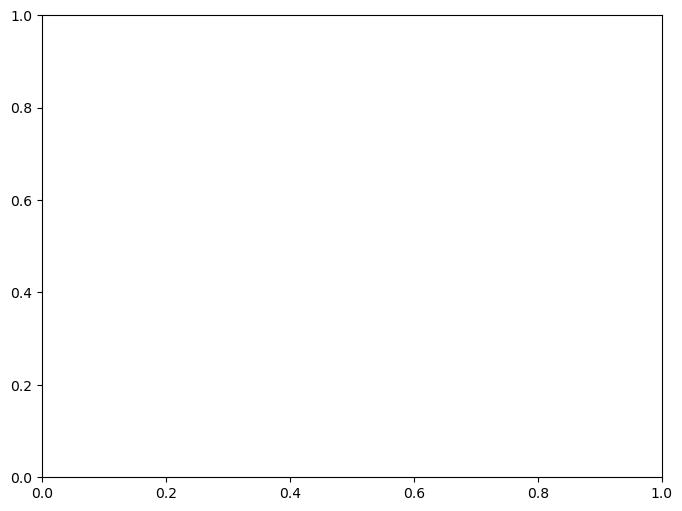

In [13]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the correlation function on a log-log scale
plt.plot(separation, xi_s, marker='o', linestyle='-', label=r'$\xi(s)$')

# Set the axes labels and title
plt.xscale('log')  # Logarithmic x-axis
plt.yscale('log')  # Logarithmic y-axis
plt.xlabel('Separation s [Mpc/h]', fontsize=12)
plt.ylabel(r'$\xi(s)$', fontsize=12)
#plt.title('Galaxy Autocorrelation Function $\xi(s)$', fontsize=14)

# Add grid, legend, and tighten layout
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()


In [14]:
xi_s

### Restart

In [ ]:
######################
minsep = 10.      # Min theta
maxsep = 90.      # Max theta
nbins = 15        # Bins in theta
nbootstrap = 500  # No. of bootstrap resampling
brute = False     # Brute force for TreeCorr
npatch = 50

config = {"min_sep": minsep, \
          "max_sep": maxsep, \
            "nbins": nbins, \
            "sep_units": 'degree', \
            "bin_type": 'Linear', \
            "brute": brute, \
            "metric": 'Arc', \
            "var_method": 'bootstrap', \
            "num_bootstrap": nbootstrap,\
            }
######################

import numpy as np
import pandas as pd
import treecorr

# Read Gxs
zmin, zmax = 0.0, 0.15
cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss  = cat_sdss[(cat_sdss["red"] > zmin)*(cat_sdss["red"] < zmax)]

# Read Randoms
cat_random = pd.read_csv('../data/random_sample_healpy_128.csv')



# TreeCorr Catalogues
#xi_bs = np.zeros((nbootstrap,nbins))
#varxi_bs = np.zeros((nbootstrap,nbins))
dd = treecorr.NNCorrelation(config)
#dr = treecorr.NNCorrelation(config)
rr = treecorr.NNCorrelation(config)
#rd = treecorr.NNCorrelation(config)

rcat = treecorr.Catalog(ra=cat_random['ra'], dec=cat_random['dec'], \
                    ra_units='deg', dec_units='deg',npatch=npatch)

gcat = treecorr.Catalog(ra=cat_sdss['ra'], dec=cat_sdss['dec'],\
                        ra_units='deg', dec_units='deg',npatch=npatch)

dd.process(gcat)
rr.process(rcat)

xi, varxi = dd.calculateXi(rr=rr)
th = dd.meanr


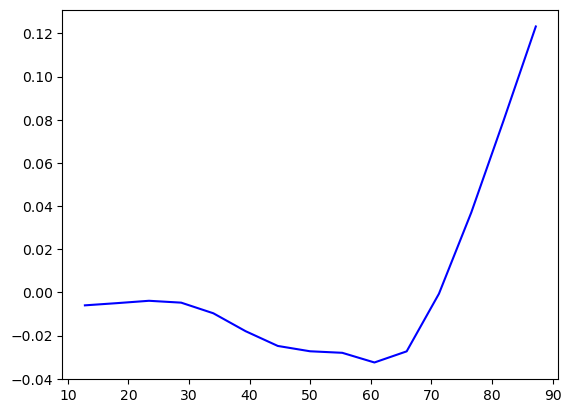

In [22]:
import matplotlib.pyplot as plt
sig = np.sqrt(varxi)

plt.plot(th, xi, color='blue')
#plt.plot(th, -xi, color='blue', ls=':')
#plt.errorbar(th[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
#plt.errorbar(th[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
#leg = plt.errorbar(-th, xi, yerr=sig, color='blue')

plt.show()

### 3d positions

In [2]:
import numpy as np
import pandas as pd
import healpy as hp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

def build_cdf_from_parabola(data, vmin, vmax, num_points=10000):
    # Create a histogram of the redshifts
    hist, bin_edges = np.histogram(data, bins=50, range=(vmin, vmax), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Fit a parabola (second-degree polynomial) to the histogram
    poly = Polynomial.fit(bin_centers, hist, deg=2)
    z_vals = np.linspace(vmin, vmax, num_points)
    pdf_vals = poly(z_vals)

    # Ensure the PDF is positive and normalized
    pdf_vals = np.clip(pdf_vals, a_min=0, a_max=None)
    pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF

    # Build the CDF
    cdf_vals = np.cumsum(pdf_vals) * (z_vals[1] - z_vals[0])
    cdf_vals /= cdf_vals[-1]  # Normalize to [0, 1]

    # Create inverse CDF via interpolation
    cdf_inv = interp1d(cdf_vals, z_vals, bounds_error=False, fill_value=(vmin, vmax))
    return cdf_inv, z_vals, pdf_vals, cdf_vals
  
# Load galaxy data
zmin, zmax = 0.05, 0.15
cat_sdss = pd.read_csv('../data/MGS_DR7_lpereyra.csv')
cat_sdss  = cat_sdss[(cat_sdss["z"] > zmin)*(cat_sdss["z"] < zmax)]
ra = cat_sdss['ra'].values  # Right Ascension
dec = cat_sdss['dec'].values  # Declination

# Set the resolution (nside)
nside = 128  # Approx 55 arcmin resolution (adjust as needed)
nrand = 3 # Times the size of the data (around 10% is left after mask)

# Total number of pixels in the map
npix = hp.nside2npix(nside)

# Initialize a mask array (1 = valid, 0 = invalid)
mask = np.zeros(npix, dtype=int)

# Convert RA, Dec to Healpix indices
theta = np.radians(90 - dec)  # Declination to colatitude
phi = np.radians(ra)          # Right Ascension to longitude
pixels = hp.ang2pix(nside, theta, phi)

# Mark these pixels as valid
mask[pixels] = 1

num_randoms = int(10e6)  # Number of random points

# Generate uniform random RA, Dec
ra_random = np.random.uniform(0, 360, num_randoms)  # RA: 0 to 360 degrees
u = np.random.uniform(-1, 1, num_randoms)
dec_random_rad = np.arcsin(u)
dec_random = np.rad2deg(dec_random_rad)
#dec_random = np.random.uniform(-90, 90, num_randoms)  # Dec: -90 to 90 degrees

# Convert RA, Dec to Healpix indices
theta_random = np.radians(90 - dec_random)
phi_random = np.radians(ra_random)
random_pixels = hp.ang2pix(nside, theta_random, phi_random)

# Apply the mask
valid_indices = mask[random_pixels] == 1
ra_random = ra_random[valid_indices]
dec_random = dec_random[valid_indices]

# Read redshift distribution and apply to randoms
# Build the inverse CDF from a smoothed KDE fit
cdf_inv_z, z_vals, pdf_vals, cdf_vals = build_cdf_from_parabola(cat_sdss['z'], zmin, zmax)

# Generate random redshifts
u = np.random.uniform(0, 1, len(ra_random))
red_random = cdf_inv_z(u)

random_data = pd.DataFrame({
    'ra': ra_random[:len(ra)*nrand],
    'dec': dec_random[:len(ra)*nrand],
    'red': red_random[:len(ra)*nrand]
})

print(len(ra))
print(len(random_data))

359437
1078311


In [ ]:
######################
minsep = 10.      # Min theta
maxsep = 150.      # Max theta
nbins = 20        # Bins in theta
nbootstrap = 10  # No. of bootstrap resampling
brute = False     # Brute force for TreeCorr
npatch = 10

config = {"min_sep": minsep, \
          "max_sep": maxsep, \
            "nbins": nbins, \
            #"sep_units": 'degree', \
            "bin_type": 'Log', \
            #"brute": brute, \
            #"metric": 'Arc', \
            #"var_method": 'bootstrap', \
            #"num_bootstrap": nbootstrap,\
            }
######################

import numpy as np
import pandas as pd
import treecorr
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)

def H(ra, dec, z):

  ra  = np.array(ra,  dtype=np.float32) 
  dec = np.array(dec, dtype=np.float32) 
  z   = np.array(z,   dtype=np.float32) 

  r = np.float32(cosmo.comoving_distance(z).value)
  x = r*np.cos(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
  y = r*np.sin(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
  z = r*np.sin(np.deg2rad(dec))
  return x, y, z

# Read Gxs
zmin, zmax = 0.05, 0.15
#cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss = pd.read_csv('../data/MGS_DR7_lpereyra.csv')
cat_sdss  = cat_sdss[(cat_sdss["z"] > zmin)*(cat_sdss["z"] < zmax)]

# Read Randoms
#cat_random = pd.read_csv('../data/random_sample_healpy_128_561286.csv')
cat_random = random_data

# Transform to Cartesian
cat_random["x"], cat_random["y"], cat_random["z"] = H(cat_random["ra"], cat_random["dec"], cat_random["red"])
cat_sdss["x"], cat_sdss["y"], cat_sdss["z"] = H(cat_sdss["ra"], cat_sdss["dec"], cat_sdss["z"])


# TreeCorr Catalogues
dd = treecorr.NNCorrelation(config)
dr = treecorr.NNCorrelation(config)
rr = treecorr.NNCorrelation(config)
#rd = treecorr.NNCorrelation(config)

rcat = treecorr.Catalog(x=cat_random['x'], y=cat_random['y'], z=cat_random['z'])#, \
                    #npatch=npatch)

gcat = treecorr.Catalog(x=cat_sdss['x'], y=cat_sdss['y'], z=cat_sdss['z'])#, \
                    #npatch=npatch)

dd.process(gcat)
rr.process(rcat)
dr.process(gcat,rcat)

xi, varxi = dd.calculateXi(rr=rr,dr=dr)
th = dd.meanr


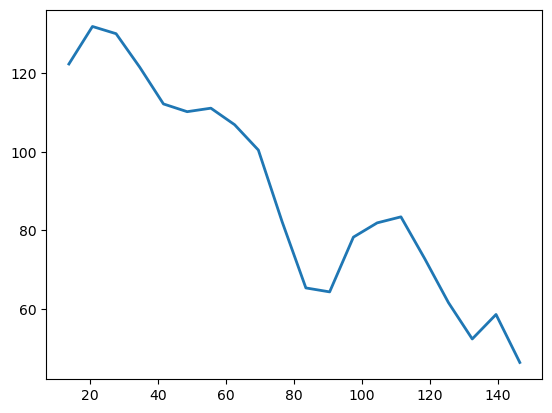

In [7]:
import matplotlib.pyplot as plt
sig = np.sqrt(varxi)

th = dd.meanr

#plt.plot(th, xi, color='C00')
#plt.yscale('log')
#plt.xscale('log')
#plt.plot(th, -xi, color='blue', ls=':')
#plt.errorbar(th[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=1)
plt.errorbar(th, xi*th**2, yerr=sig, color='C00', lw=2)

#plt.errorbar(th[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
#leg = plt.errorbar(-th, xi, yerr=sig, color='blue')

plt.show()

In [ ]:
dd.

In [23]:
def get_xi3d(cat_sdss,cat_random):
    ######################
    minsep = 90.      # Min theta
    maxsep = 140.      # Max theta
    nbins = 10        # Bins in theta
    #nbootstrap = 500  # No. of bootstrap resampling
    #brute = False     # Brute force for TreeCorr
    npatch = 10

    config = {"min_sep": minsep, \
                "max_sep": maxsep, \
                "nbins": nbins, \
                #"sep_units": 'degree', \
                "bin_type": 'Linear', \
                #"brute": brute, \
                #"metric": 'Arc', \
                "var_method": 'jackknife', \
                #"num_bootstrap": nbootstrap,\
                }
    ######################

    import numpy as np
    import pandas as pd
    import treecorr
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)

    def H(ra, dec, z):

        ra  = np.array(ra,  dtype=np.float32) 
        dec = np.array(dec, dtype=np.float32) 
        z   = np.array(z,   dtype=np.float32) 

        r = np.float32(cosmo.comoving_distance(z).value)
        x = r*np.cos(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
        y = r*np.sin(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
        z = r*np.sin(np.deg2rad(dec))
        return x, y, z

    cat_random["x"], cat_random["y"], cat_random["z"] = H(cat_random["ra"], cat_random["dec"], cat_random["red"])

    # TreeCorr Catalogues
    dd = treecorr.NNCorrelation(config)
    dr = treecorr.NNCorrelation(config)
    rr = treecorr.NNCorrelation(config)

    rcat = treecorr.Catalog(x=cat_random['x'], y=cat_random['y'], z=cat_random['z'], npatch=npatch)

    gcat = treecorr.Catalog(x=cat_sdss['x'], y=cat_sdss['y'], z=cat_sdss['z'], npatch=npatch)

    dd.process(gcat)
    rr.process(rcat)
    dr.process(gcat,rcat)

    xi, varxi = dd.calculateXi(rr=rr,dr=dr)
    r = dd.meanr
    return xi, varxi, r

# Read Gxs
zmin, zmax = 0.0, 0.15
cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss  = cat_sdss[(cat_sdss["red"] > zmin)*(cat_sdss["red"] < zmax)]

# Filament Gxs
filgxs = cat_sdss[cat_sdss['dist_fil']<=3.]

# Non-filament Gxs
nonfilgxs = cat_sdss[cat_sdss['dist_fil']>8.25]

# Read Randoms
cat_random = pd.read_csv('../data/random_sample_healpy_128.csv')

xi, varxi, r = get_xi3d(cat_sdss,cat_random)

xi_filgxs, varxi_filgxs, r = get_xi3d(filgxs,cat_random)

xi_nonfilgxs, varxi_nonfilgxs, r = get_xi3d(nonfilgxs,cat_random)


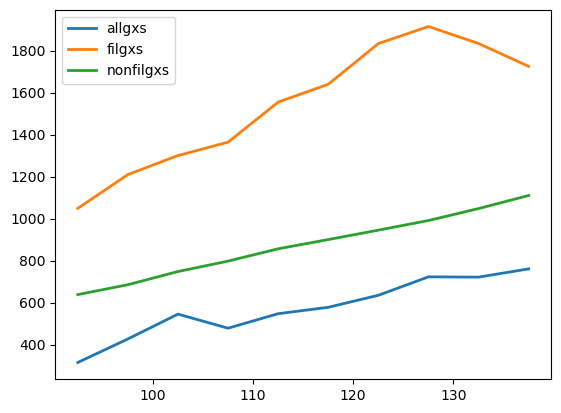

In [ ]:
import matplotlib.pyplot as plt
sig = np.sqrt(varxi)
sig_filgxs = np.sqrt(varxi_filgxs)
sig_nonfilgxs = np.sqrt(varxi_nonfilgxs)

# plt.errorbar(r, xi, yerr=sig, color='C00', lw=2, label='allgxs')
# plt.errorbar(r, xi_filgxs, yerr=sig_filgxs, color='C01', lw=2, label='filgxs')
# plt.errorbar(r, xi_nonfilgxs, yerr=sig_filgxs, color='C02', lw=2, label='nonfilgxs')

plt.plot(r, xi*r**2, color='C00', lw=2, label='allgxs')
plt.plot(r, xi_filgxs*r**2, color='C01', lw=2, label='filgxs')
plt.plot(r, xi_nonfilgxs*r**2, color='C02', lw=2, label='nonfilgxs')

plt.legend()

plt.show()

#### Pruebita

In [1]:
import numpy as np
import pandas as pd
import treecorr
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)

def H(ra, dec, z):

  ra  = np.array(ra,  dtype=np.float32) 
  dec = np.array(dec, dtype=np.float32) 
  z   = np.array(z,   dtype=np.float32) 

  r = np.float32(cosmo.comoving_distance(z).value)
  x = r*np.cos(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
  y = r*np.sin(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
  z = r*np.sin(np.deg2rad(dec))
  return x, y, z

# Read Gxs
# zmin, zmax = 0.0, 0.15
# cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
# cat_sdss  = cat_sdss[(cat_sdss["red"] > zmin)*(cat_sdss["red"] < zmax)]

# Read Randoms
cat_random = pd.read_csv('../data/random_sample_healpy_128_561286.csv')

cat_random["x"], cat_random["y"], cat_random["z"] = H(cat_random["ra"], cat_random["dec"], cat_random["red"])

In [2]:
cat_random['x']

0        -316.680511
1        -264.269836
2        -299.262665
3        -417.088928
4        -472.110840
             ...    
561281   -202.734024
561282   -110.232574
561283   -277.995972
561284   -268.451904
561285   -356.731598
Name: x, Length: 561286, dtype: float32

In [6]:
import healpy as hp

r = np.float32(cosmo.comoving_distance(cat_random['red']).value)

print(r.reshape(-1,1))

[[509.1177 ]
 [315.7677 ]
 [306.5307 ]
 ...
 [345.80328]
 [379.9954 ]
 [473.3747 ]]


In [8]:
hp.ang2vec?

Signature: hp.ang2vec(theta, phi, lonlat=False)
Docstring:
ang2vec : convert angles to 3D position vector

Parameters
----------
theta : float, scalar or arry-like
  colatitude in radians measured southward from north pole (in [0,pi]).
phi : float, scalar or array-like
  longitude in radians measured eastward (in [0, 2*pi]).
lonlat : bool
  If True, input angles are assumed to be longitude and latitude in degree,
  otherwise, they are co-latitude and longitude in radians.

Returns
-------
vec : float, array
  if theta and phi are vectors, the result is a 2D array with a vector per row
  otherwise, it is a 1D array of shape (3,)

See Also
--------
vec2ang, rotator.dir2vec, rotator.vec2dir
File:      ~/anaconda3/envs/filbao/lib/python3.12/site-packages/healpy/pixelfunc.py
Type:      function

In [ ]:
coord = hp.ang2vec(cat_random["ra"], cat_random["dec"], lonlat=True)*r.reshape((-1,1))

In [13]:
coord[:,0]-cat_random['x']

0         0.000057
1        -0.000091
2         0.000411
3         0.000104
4        -0.000108
            ...   
561281   -0.001238
561282    0.000430
561283   -0.000393
561284   -0.000491
561285    0.000599
Name: x, Length: 561286, dtype: float64